In [269]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

def find_project_root(marker=".gitignore"):
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent.resolve()
    raise FileNotFoundError(
        f"Project root marker '{marker}' not found starting from {current}")
    
root = find_project_root()

In [270]:
triangulation_results_path = f"{root}/data/stereo_detections_triangulated.csv"
triangulation_results = pd.read_csv(triangulation_results_path)
triangulation_results.sort_values(by='frame_no', inplace=True)

with pd.option_context('display.max_colwidth', None):
  print(triangulation_results['position_3d_pixels'].head())

0       [3748.34950574466, -489.8600736323993, 4286.859981600735]
1      [3491.804443536914, -456.8706049838067, 4269.054799920354]
2     [3180.6963959369436, -416.8508687861151, 4172.307555379583]
3     [3830.540950410358, -433.39021907640875, 5382.764621454251]
4    [3835.8875062889883, -437.38462018886327, 5396.051789531503]
Name: position_3d_pixels, dtype: object


In [271]:
frame_start, frame_end = 1160, 1211

filtered_shot = triangulation_results.loc[
    (triangulation_results['frame_no'] >= frame_start) &
    (triangulation_results['frame_no'] <= frame_end)
].copy()

# Savitzky-Golay Filter

In [272]:
import numpy as np
import ast
from scipy.signal import savgol_filter

points_3d = np.array([ast.literal_eval(p) for p in filtered_shot['position_3d_pixels']])
z_vals = points_3d[:, 2]

z_smooth = savgol_filter(z_vals, window_length=7, polyorder=2)

# Optional: Add to DataFrame
filtered_shot['z'] = z_vals
filtered_shot['z_smooth'] = z_smooth


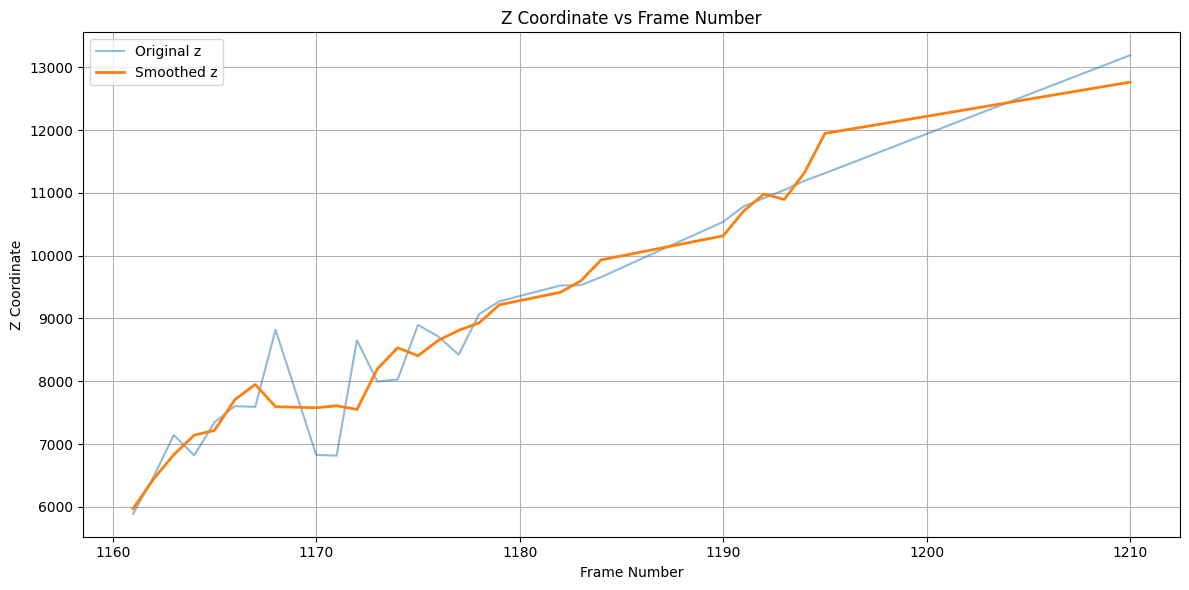

In [273]:
def plot_z_vs_frame(frame_no, z, z_smooth=None):
    plt.figure(figsize=(12, 6))

    # Plot original z
    plt.plot(frame_no, z, label='Original z', alpha=0.5)

    # Plot smoothed z if provided
    if z_smooth is not None:
        plt.plot(frame_no, z_smooth, label='Smoothed z', linewidth=2)

    plt.xlabel('Frame Number')
    plt.ylabel('Z Coordinate')
    plt.title('Z Coordinate vs Frame Number')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
plot_z_vs_frame(
    frame_no=filtered_shot['frame_no'],
    z=filtered_shot['z'],
    z_smooth=filtered_shot['z_smooth']  # optional
)

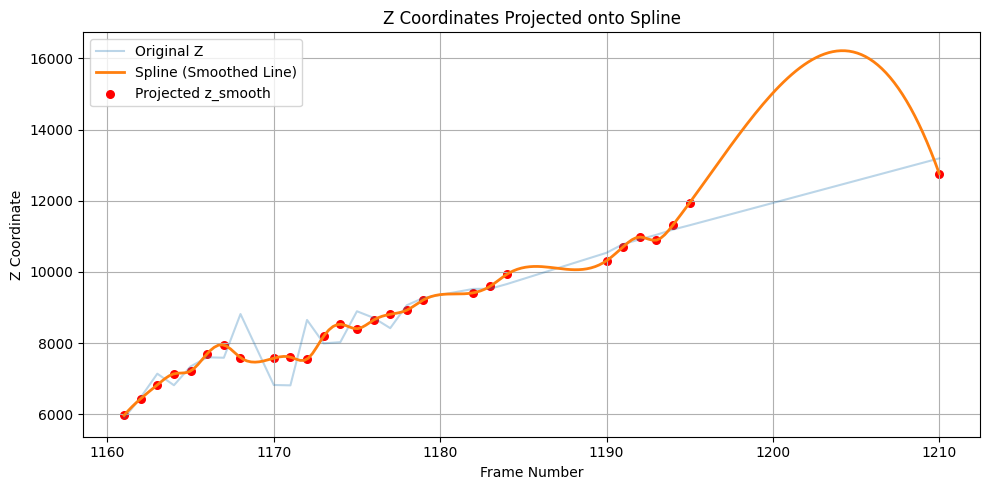

In [274]:
import numpy as np
import ast
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.interpolate import make_interp_spline

# Sort just to be safe
filtered_shot.sort_values('frame_no', inplace=True)

# Extract frame and z_smooth
frame = filtered_shot['frame_no'].values
z = filtered_shot['z_smooth'].values

# Fit spline to the smoothed z values
spline = make_interp_spline(frame, z)

# Interpolate z values at the original frame_no points
z_projected = spline(frame)

# Update the DataFrame to shift z_smooth onto the spline
filtered_shot['z_smooth'] = z_projected

# Optional: plot for visual check
frame_dense = np.linspace(frame.min(), frame.max(), 200)
z_dense = spline(frame_dense)

plt.figure(figsize=(10, 5))
plt.plot(frame, filtered_shot['z'], label='Original Z', alpha=0.3)
plt.plot(frame_dense, z_dense, label='Spline (Smoothed Line)', linewidth=2)
plt.scatter(frame, z_projected, color='red', label='Projected z_smooth', s=30)
plt.xlabel("Frame Number")
plt.ylabel("Z Coordinate")
plt.title("Z Coordinates Projected onto Spline")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Rolling Smooth Window

In [275]:
# filtered_shot['z_smooth'] = filtered_shot['z'].rolling(window=5, center=True).mean()

# plot_z_vs_frame(
#     frame_no=filtered_shot['frame_no'],
#     z=filtered_shot['z'],
#     z_smooth=filtered_shot['z_smooth']
# )

# Update stereo_detections_triangulation.csv to use 'z_smooth'

In [276]:
coords = np.array([ast.literal_eval(p) for p in filtered_shot['position_3d_pixels']])

# Extract the X and Y components from coords and the smoothed Z from the DataFrame
filtered_shot['position_3d_pixels_smooth'] = [
    [float(x), float(y), float(z)]
    for (x, y), z in zip(coords[:, :2], filtered_shot['z_smooth'])
]

# Drop helper columns
filtered_shot.drop(['z', 'z_smooth'], axis=1, inplace=True)

# Save to CSV
filtered_shot.to_csv(f"{root}/data/stereo_detections_triangulated_with_smooth.csv", index=False)

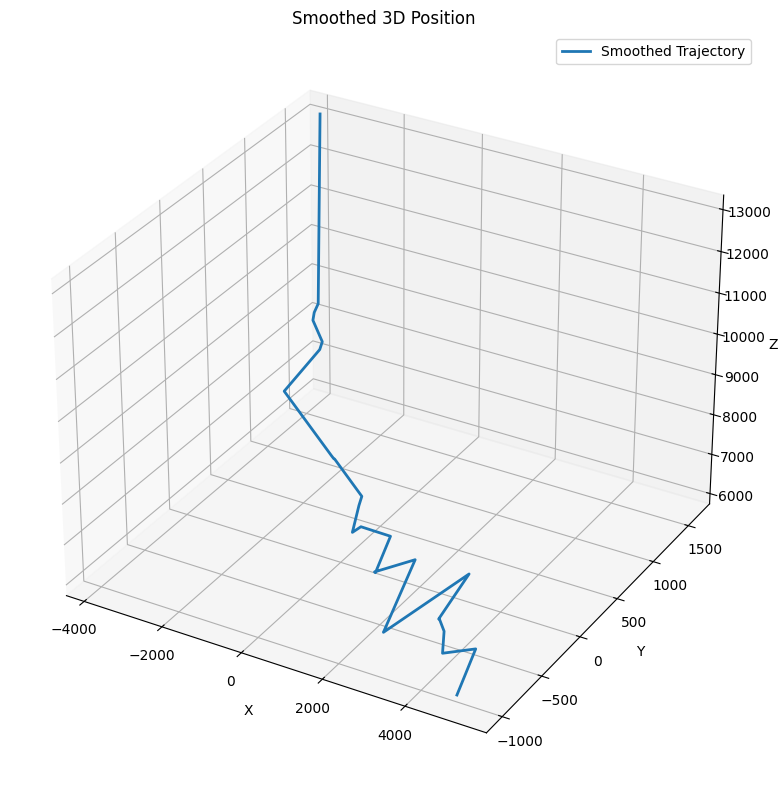

In [277]:
def plot_3d_trajectory(coords, title='3D Trajectory'):

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], label='Smoothed Trajectory', linewidth=2)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()
    

plot_3d_trajectory(coords, title='Smoothed 3D Position')
